In [ ]:
!pip install transformers
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from google.colab import drive
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from datasets import Dataset


# Mount Google Drive
drive.mount('/gdrive')
root = '/gdrive/My Drive/Kaggle'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# 1. Load Data
train_df = pd.read_csv(f'{root}/train.csv')
test_df = pd.read_csv(f'{root}/test.csv')
sample_submission_df = pd.read_csv(f'{root}/sample_submission.csv')

In [ ]:

# 2. Preprocess Data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Prepare dataset for Hugging Face Trainer
train_dataset = Dataset.from_pandas(train_df[['text', 'target']])
train_dataset = train_dataset.map(tokenize_function, batched=True)
train_dataset = train_dataset.rename_column("target", "labels")
train_dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])

test_dataset = Dataset.from_pandas(test_df[['text']])
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type="torch", columns=['input_ids', 'attention_mask'])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/7613 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [ ]:

# Split train data into train and validation sets
train_dataset, val_dataset = train_dataset.train_test_split(test_size=0.1).values()

# 3. Build the Model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.44.2",
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/model.safetensors
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification

In [31]:
from transformers import IntervalStrategy
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,  # Increase the epochs to better understand trends
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy=IntervalStrategy.EPOCH,
    save_strategy=IntervalStrategy.EPOCH,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",
    load_best_model_at_end=True,
    save_total_limit=1,
    disable_tqdm=False,
    logging_first_step=True,
    log_level="info",
    log_level_replica="warning",
    weight_decay=0.01,  # Regularization to reduce overfitting
    gradient_accumulation_steps=4,
    learning_rate=1e-5  # Lower learning rate
)

# Define the data collator and trainer as before
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stop if no improvement for 3 evaluations
)

trainer.train()


PyTorch: setting up devices
***** Running training *****
  Num examples = 6,165
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 3,840
  Number of trainable parameters = 66,955,010


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [28]:
# 5. Make Predictions
predictions = trainer.predict(test_dataset)
pred_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()

# 6. Prepare Submission
submission_df = sample_submission_df.copy()
submission_df['target'] = pred_labels
submission_df.to_csv(f'{root}/submission_graph.csv', index=False)

print("Submission file 'submission.csv' created in your Google Drive Kaggle folder.")


***** Running Prediction *****
  Num examples = 3263
  Batch size = 8


Submission file 'submission.csv' created in your Google Drive Kaggle folder.


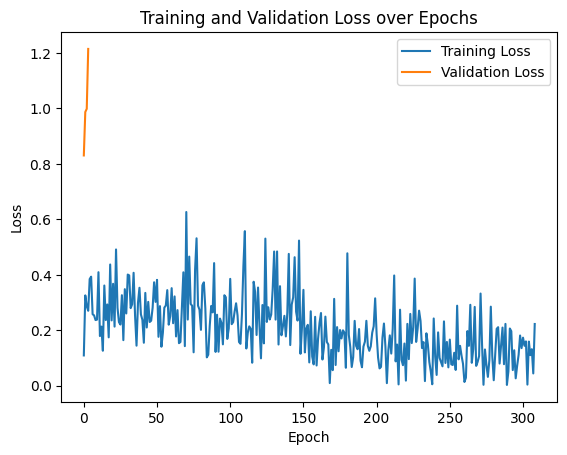

In [29]:
import matplotlib.pyplot as plt

# Assuming `trainer.state.log_history` contains the logged loss values
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
val_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()
